# Libraries

In [ ]:
import  pandas            as pd
import  numpy             as np
import  plotly.express    as px
import  matplotlib.pyplot as plt
import  plotly.graph_objs as go
import  plotly.io         as pio
from    plotly.subplots         import make_subplots
from    sklearn.model_selection import train_test_split
from    sklearn.impute          import SimpleImputer
from    imblearn.over_sampling  import SMOTE
from    sklearn.preprocessing   import StandardScaler
from    sklearn.ensemble        import RandomForestClassifier
from    xgboost                 import XGBClassifier
from    sklearn.neural_network  import MLPClassifier
from    sklearn.ensemble        import AdaBoostClassifier
from    sklearn.model_selection import RandomizedSearchCV
from    sklearn.model_selection import cross_validate
from    sklearn.metrics         import make_scorer
from    sklearn.metrics         import accuracy_score
from    sklearn.metrics         import confusion_matrix
from    sklearn.metrics         import precision_score
from    sklearn.metrics         import recall_score
from    sklearn.metrics         import f1_score
from    sklearn.metrics         import roc_auc_score
from    sklearn.metrics         import ConfusionMatrixDisplay
from    sklearn.metrics         import RocCurveDisplay

In [ ]:
RANDOM_SEED = np.random.seed(31)

In [ ]:
cd ..\

# Train

In [ ]:
df_train = pd.read_csv('data\\original\\air_system_previous_years.csv',
                       encoding='utf-8',
                       na_values=['na']
                      )
df_train.head()

In [ ]:
df_isna = df_train.drop(columns='class')
df_isna = df_isna.isna().sum().sort_values(ascending=False).to_frame('total_nan')
df_isna['total_data'] = df_train.shape[0]
df_isna['pct_nan'] = (df_isna['total_nan'] / df_isna['total_data'] * 100).round(2)
df_isna

In [ ]:
fig = px.bar(df_isna,
             x=df_isna.index,
             y='pct_nan',
             text_auto='pct_nan'
             )
fig.update_layout(height=400,
                  width=800,
                  showlegend=True,
                  margin=dict(l=10, r=10, b=10, t=10),
                  yaxis=dict(title='Total NaN (%)', dtick=10),
                  xaxis=dict(title='Feature')
                  )
fig.show()

In [ ]:
# Remove features with over 50% of NaN data
features_low_nan = df_isna[df_isna['pct_nan'] <= 50].index.to_list()

In [ ]:
df_features = df_train[features_low_nan].astype(float)

# Change class object to int dummies
map_class = {'neg': 0, 'pos': 1}
df_target = df_train['class'].map(map_class).to_frame('class').astype(int)

In [ ]:
df_count_class = df_target.value_counts().to_frame()
df_count_class

In [ ]:
fig = px.bar(df_count_class,
             x=df_count_class.index.get_level_values('class'),
             y='count',
             text_auto='count'
             )
fig.update_layout(height=400,
                  width=800,
                  showlegend=True,
                  margin=dict(l=10, r=10, b=10, t=10),
                  yaxis=dict(title='Total'),
                  xaxis=dict(title='Class',
                             tickvals=['neg', 'pos'],
                             ticktext=['Negative', 'Positive'])
                  )
fig.show()

In [ ]:
# Calculate events proportion
total     = df_target.shape[0]
non_event = df_target[df_target['class'] == 0].shape[0]
event     = df_target[df_target['class'] == 1].shape[0]

non_event_percent = round(non_event / total * 100, 2)
event_percent     = round(event / total * 100, 2)

df_percent_events = pd.DataFrame([non_event_percent, event_percent],
                                 columns=['percent'],
                                 index=['non_event', 'event']
                                 )
df_percent_events

In [ ]:
fig = px.bar(df_percent_events,
             x=df_percent_events.index,
             y='percent',
             text_auto=True
             )
fig.update_layout(height=400,
                  width=800,
                  showlegend=True,
                  margin=dict(l=10, r=10, b=10, t=10),
                  yaxis = dict(title='Total (%)'),
                  xaxis = dict(title='Class',
                               tickvals=['non_event', 'event'],
                               ticktext=['Negative', 'Positive'])
                  )
fig.show()

In [ ]:
# Identify features with zero variance
features_zero_variance = [col for col in df_features if df_features[col].std() == 0]
print(features_zero_variance)
df_features.drop(columns=features_zero_variance, inplace=True)

## Split train and validation

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_features, df_target, test_size=0.3, random_state=RANDOM_SEED)

## Input data on NaN

In [ ]:
# Use the median to replace NaN values
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit(X_train)

# # Save the imputer to a file
# with open('train_artifacts\\simple_imputer.pkl', 'wb') as file:
#     pickle.dump(imputer, file)

# # Load the imputer from the file
# with open('train_artifacts\\simple_imputer.pkl', 'rb') as file:
#     imputer = pickle.load(file)

# Fill NaN on train
X_train_filled_nan = imputer.transform(X_train)
X_train_filled_nan = pd.DataFrame(X_train_filled_nan, columns=X_train.columns)
print(X_train_filled_nan.isna().sum().sum())

# Fill NaN on validation
X_val_filled_nan = imputer.transform(X_val)
X_val_filled_nan = pd.DataFrame(X_val_filled_nan, columns=X_train.columns)
print(X_val_filled_nan.isna().sum().sum())

In [ ]:
df_val = X_val_filled_nan.join(y_val)
df_val.head()

## Balance data

In [ ]:
# Balance train data minority class
oversample = SMOTE(sampling_strategy='minority', random_state=RANDOM_SEED)
oversample.fit(X_train_filled_nan, y_train)

# # Save the oversample to a file
# with open('train_artifacts\\oversample.pkl', 'wb') as file:
#     pickle.dump(oversample, file)

# # Load the oversample from the file
# with open('train_artifacts\\oversample.pkl', 'rb') as file:
#     oversample = pickle.load(file)

# Data balanced
X_train_balanced, y_train_balanced = oversample.fit_resample(X_train_filled_nan, y_train)
# y train form dataframe to series
y_train_balanced = y_train_balanced['class']

In [ ]:
df_train_balanced = X_train_balanced.join(y_train_balanced)
df_train_balanced.head()

In [ ]:
# Calculate train events proportion
size_train_balanced      = df_train_balanced.shape[0]
non_event_train_balanced = df_train_balanced[df_train_balanced['class'] == 0].shape[0]
event_Train_balanced     = df_train_balanced[df_train_balanced['class'] == 1].shape[0]

non_event_train_balanced_percent = round(non_event_train_balanced / size_train_balanced * 100, 2)
event_train_balanced_percent     = round(event_Train_balanced / size_train_balanced * 100, 2)

non_event_train_balanced_percent, event_train_balanced_percent

In [ ]:
# Calculate validation events proportion
size_val      = df_val.shape[0]
non_event_val = df_val[df_val['class'] == 0].shape[0]
event_val     = df_val[df_val['class'] == 1].shape[0]

non_event_val_percent = round(non_event_val / size_val * 100, 2)
event_val_percent     = round(event_val / size_val * 100, 2)

non_event_val_percent, event_val_percent

## Correlations

In [ ]:
# df_train_corr = df_train_balanced.corr().round(2)

# fig = go.Figure()
# fig.add_trace(
#     go.Heatmap(
#         x=df_train_corr.columns,
#         y=df_train_corr.index,
#         z=np.array(df_train_corr),
#         text=df_train_corr.values,
#         texttemplate='%{text:.4f}',
#         colorscale='viridis'))

# fig.update_layout(
#     height=2000,
#     width=2000,
#     yaxis=dict(autorange='reversed'))

# html_file ='temp_plot.html'
# pio.write_html(fig, file=html_file, auto_open=True)

# Functions

In [ ]:
def calculate_metrics_standard_cutoff(y_test, y_predict):
    no_defect_cost  = 10
    preventive_cost = 25
    corrective_cost = 500
    
    accuracy       = accuracy_score(y_test, y_predict)
    precision      = precision_score(y_test, y_predict, zero_division=0)
    recall         = recall_score(y_test, y_predict, zero_division=0)
    f1score        = f1_score(y_test, y_predict, zero_division=0)
    auc_value      = roc_auc_score(y_test, y_predict)
    tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
    specificity    = tn / (tn + fp)

    false_positive_rate       = fp / (fp + tn) * 100
    false_negative_rate       = fn / (fn + tp) * 100
    false_classification_rate = (fp + fn) / y_predict.shape[0] * 100

    no_defect_maintenance_cost  = fp * no_defect_cost
    preventive_maintenance_cost = tp * preventive_cost
    corrective_maintenance_cost = fn * corrective_cost
    total_maintenance_cost      = no_defect_maintenance_cost \
                                     + preventive_maintenance_cost \
                                     + corrective_maintenance_cost
    
    metrics = []
    metrics.append([accuracy,
                    precision,
                    recall,
                    f1score,
                    auc_value,
                    specificity,
                    tn, fp, fn, tp,
                    false_positive_rate,
                    false_negative_rate,
                    false_classification_rate,
                    no_defect_maintenance_cost,
                    preventive_maintenance_cost,
                    corrective_maintenance_cost,
                    total_maintenance_cost]  
                  )
    print(f'Accuracy:        {accuracy:.2f}')
    print(f'Precision:       {precision:.2f}')
    print(f'Recall:          {recall:.2f}')
    print(f'F1-score:        {f1score:.2f}')
    print(f'Specificity:     {specificity:.2f}')
    print(f'AUC:             {auc_value:.2f}\n')
    print(f'TN:              {tn:.2f}')
    print(f'TP:              {tp:.2f}')
    print(f'FN:              {fn:.2f}')
    print(f'FP:              {fp:.2f}\n')
    print(f'FP rate:         {false_positive_rate:.2f}%')
    print(f'FN rate:         {false_negative_rate:.2f}%')
    print(f'False clf rate:  {false_classification_rate:.2f}%\n')
    print(f'No defect cost:  {no_defect_maintenance_cost:.2f}')
    print(f'Predictive cost: {preventive_maintenance_cost:.2f}')
    print(f'Corrective cost: {corrective_maintenance_cost:.2f}')
    print(f'Total cost:      {total_maintenance_cost:.2f}\n')

    cm = confusion_matrix(y_val, y_predict)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.show()

    RocCurveDisplay.from_predictions(y_val, y_predict).plot

    return metrics

In [ ]:
def calculate_metrics_range_cutoff(dataframe_predict_proba, y_test):
    no_defect_cost  = 10
    preventive_cost = 25
    corrective_cost = 500
    results = []
    for cutoff in np.arange(0.05, 0.99, 0.05):
        y_predict      = np.where(dataframe_predict_proba['proba_event'] > cutoff, 1, 0)
        accuracy       = accuracy_score(y_test, y_predict)
        precision      = precision_score(y_test, y_predict, zero_division=0)
        recall         = recall_score(y_test, y_predict, zero_division=0)
        f1score        = f1_score(y_test, y_predict, zero_division=0)
        auc_value      = roc_auc_score(y_test, y_predict)
        tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
        specificity    = tn / (tn + fp)

        false_positive_rate       = fp / (fp + tn) * 100
        false_negative_rate       = fn / (fn + tp) * 100
        false_classification_rate = (fp + fn) / y_predict.shape[0] * 100

        no_defect_maintenance_cost  = fp * no_defect_cost
        preventive_maintenance_cost = tp * preventive_cost
        corrective_maintenance_cost = fn * corrective_cost
        total_maintenance_cost      = no_defect_maintenance_cost \
                                       + preventive_maintenance_cost \
                                        + corrective_maintenance_cost
                                
        results.append([cutoff, accuracy, precision,
                        recall, f1score,
                        auc_value, tn, fp, fn, tp,
                        specificity, false_positive_rate,
                        false_negative_rate, false_classification_rate,
                        no_defect_maintenance_cost,
                        preventive_maintenance_cost,
                        corrective_maintenance_cost,
                        total_maintenance_cost]
                    )
        
        df_metrics = pd.DataFrame(results,
                                  columns=['cutoff', 'accuracy', 'precision',
                                           'recall', 'f1score' , 'auc_value',
                                           'tn', 'fp', 'fn', 'tp',
                                           'specificity', 'false_positive_rate',
                                           'false_negative_rate', 'false_classification_rate',
                                           'no_defect_maintenance_cost',
                                           'preventive_maintenance_cost',
                                           'corrective_maintenance_cost',
                                           'total_maintenance_cost']
                                 )
        
    return df_metrics

In [ ]:
def plot_metrics(dataframe_proba):
    min_total_cost = dataframe_proba['total_maintenance_cost'].min()
    best_cutoff    = dataframe_proba.loc[dataframe_proba['total_maintenance_cost'] \
                                         == min_total_cost]['cutoff'].values[0]
    fig = make_subplots(rows=3, cols=1,
                        vertical_spacing=0.08,
                        horizontal_spacing=0.06,
                        shared_xaxes=False,
                        subplot_titles=['Rates', 'Metrics', 'Costs']
                        )

    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['false_negative_rate'],
        name='FN rate',
        mode='lines',
        line=dict(color='#eb3040')
        ),
        row=1, col=1
        )

    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['false_positive_rate'],
        name='FP rate',
        mode='lines',
        line=dict(color='#eb6949')
        ),
        row=1, col=1
        )
        

    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['false_classification_rate'],
        name='False classification rate',
        mode='lines',
        line=dict(color='#eb8d27')
        ),
        row=1, col=1
        )

    # ***********************************************
    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['accuracy'],
        name='Accuracy',
        mode='lines',
        line=dict(color='#85ab71')
        ),
        row=2, col=1
        )

    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['precision'],
        name='Precision',
        mode='lines',
        line=dict(color='#5e8d6f')
        ),
        row=2, col=1
        )

    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['recall'],
        name='Recall',
        mode='lines',
        line=dict(color='#58b69e')
        ),
        row=2, col=1
        )

    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['f1score'],
        name='F1-score',
        mode='lines',
        line=dict(color='#c87499')
        ),
        row=2, col=1
        )

    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['specificity'],
        name='Specificity',
        mode='lines',
        line=dict(color='#cb4d8e')
        ),
        row=2, col=1
        )

    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['auc_value'],
        name='AUC',
        mode='lines',
        line=dict(color='#988921')
        ),
        row=2, col=1
        )

    # ***********************************************
    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['no_defect_maintenance_cost'],
        name='No defect maintenance cost',
        mode='lines',
        line=dict(color='green')
        ),
        row=3, col=1
        )
    
    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['preventive_maintenance_cost'],
        name='Preventive maintenance cost',
        mode='lines',
        line=dict(color='purple')
        ),
        row=3, col=1
        )
    
    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['corrective_maintenance_cost'],
        name='Corrective maintenance cost',
        mode='lines',
        line=dict(color='red')
        ),
        row=3, col=1
        )
    
    fig.add_trace(go.Scatter(
        x=dataframe_proba['cutoff'],
        y=dataframe_proba['total_maintenance_cost'],
        name='Total maintenance cost',
        mode='lines',
        line=dict(color='blue')
        ),
        row=3, col=1
        )
    
    fig.add_vline(x=best_cutoff,
                  line_dash='dash',
                  label=dict(text=f'Best cutoff {best_cutoff:.2f} \
                             <br>Lower total cost',
                             xanchor='left',
                             yanchor='top')
                  )

    fig.update_layout(height=1200,
                      width=1000,
                      showlegend=True,
                      margin=dict(l=10, r=10, b=10, t=30, pad=0),
                      xaxis1=dict(title='Cutoff', dtick=0.05, range=(0, 1)),
                      xaxis2=dict(title='Cutoff', dtick=0.05, range=(0, 1)),
                      xaxis3=dict(title='Cutoff', dtick=0.05, range=(0, 1)),
                      yaxis1=dict(title='%'),
                      # yaxis2=dict(title='%'),
                      yaxis3=dict(title='US$'),
                      )

    fig.show()

In [ ]:
def plot_cross_validation_score(cv_results, score):
    plot_fig, plot_ax = plt.subplots(figsize=(8, 4))
    plot_ax.plot(cv_results[f'train_{score}'],
                 marker='o',
                 linestyle='-',
                 color='blue',
                 label='Train'
                )
    plot_ax.plot(cv_results[f'test_{score}'],
                 marker='o',
                 linestyle='-',
                 color='red',
                 label='Validation'
                )
    plot_ax.set_xlabel('Iteration')
    plot_ax.set_xticks(range(1, len(cv_results[f'train_{score}'])))
    plot_ax.set_ylabel('Score')
    plot_ax.set_title(f'Cross-validation {score} score')
    plot_ax.legend()
    plot_ax.grid(True)

In [ ]:
def calculate_feature_importance(model):
    # Calculate feature importance (Gini)
    feat_importance    = model.feature_importances_
    df_feat_importance = pd.DataFrame({'feature'   : model.feature_names_in_,
                                       'importance': feat_importance}
                                      ).sort_values('importance', ascending=True)

    plt.figure(figsize=(8, 4))
    plt.boxplot(x=df_feat_importance['importance'], vert=False)
    plt.xlabel('Importance')
    plt.title('Feature importance distribution')

    df_feat_importance_no_zero = df_feat_importance[df_feat_importance['importance'] > 0]
    plt.figure(figsize=(8, 10))
    plt.barh(df_feat_importance_no_zero['feature'], df_feat_importance_no_zero['importance'])
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title(f'{df_feat_importance_no_zero.shape[0]} importance greater than 0')

    return df_feat_importance_no_zero

# Model

## Random forest

In [ ]:
parameters_rf_clf = {
    "model_parameters": {
        "n_estimators": [5, 100],
        "criterion": ["gini"],
        "max_depth": [2, 13],
        "min_samples_split": [0.2, 1],
        "min_samples_leaf": [1, 7]
    },
    "cross_validation": {
        "n_iterations": 5,
        "folders": 5,
        "scores": [
            "recall",
            "f1_macro",
            "roc_auc",
            "precision_macro"
        ]
    },
    "maintenance_cost": {
        "no_defect_cost": 10,
        "preventive_cost": 25,
        "corrective_cost": 500
    },
    "target": "class",
    "cutoff": 0.3,
    "model_name": "rand_forest",
    "predict_method": "predict_proba"
}

In [ ]:
def create_hyper_parameters_rf_clf(parameters: dict):
    range_n_estimators = np.arange(start=round(parameters.get('model_parameters')['n_estimators'][0], 2),
                                   stop=round(parameters.get('model_parameters')['n_estimators'][-1], 2),
                                   step=5
                                   )
    range_max_depth = np.arange(start=round(parameters.get('model_parameters')['max_depth'][0], 2),
                                stop=round(parameters.get('model_parameters')['max_depth'][-1], 2),
                                step=2
                                )
    range_min_samples_split = np.arange(start=round(parameters.get('model_parameters')['min_samples_split'][0], 2),
                                        stop=round(parameters.get('model_parameters')['min_samples_split'][-1], 2),
                                        step=0.1
                                        )
    range_min_samples_leaf = np.arange(start=round(parameters.get('model_parameters')['min_samples_leaf'][0], 2),
                                       stop=round(parameters.get('model_parameters')['min_samples_leaf'][-1], 2),
                                       step=1
                                       )
    param_distributions = {'n_estimators'     : range_n_estimators,
                           'max_depth'        : range_max_depth,
                           'min_samples_split': range_min_samples_split,
                           'min_samples_leaf' : range_min_samples_leaf
                          }
    
    return param_distributions

### Simple model

In [ ]:
rf_clf = RandomForestClassifier(random_state=RANDOM_SEED)
rf_clf.fit(X_train_balanced, y_train_balanced)

#### Cross-validation scores

In [ ]:
cv_results_rf_clf = cross_validate(estimator=rf_clf,
                                   X=X_train_balanced,
                                   y=y_train_balanced,
                                   scoring=parameters_rf_clf.get('cross_validation')['scores'],
                                   cv=parameters_rf_clf.get('cross_validation')['folders'],
                                   verbose=0,
                                   return_train_score=True,
                                   error_score=np.nan
                                   )

# Calculate cross-validation scores
for score in parameters_rf_clf.get('cross_validation')['scores']:
    cv_train_mean = cv_results_rf_clf[f'train_{score}'].mean().round(4)
    cv_test_mean  = cv_results_rf_clf[f'test_{score}'].mean().round(4)
    plot_cross_validation_score(cv_results_rf_clf, score)
    print(f'>>>>>>>>> CV {score} train mean: {cv_train_mean}')
    print(f'>>>>>>>>> CV {score} test mean:  {cv_test_mean}')

In [ ]:
y_pred_rf_clf       = rf_clf.predict(X_val_filled_nan)
y_pred_proba_rf_clf = rf_clf.predict_proba(X_val_filled_nan)

In [ ]:
metrics_rf_clf = calculate_metrics_standard_cutoff(y_val, y_pred_rf_clf)

In [ ]:
df_pred_proba_rf_clf = pd.DataFrame(y_pred_proba_rf_clf,
                                    columns=['proba_non_event', 'proba_event']
                                    )
df_pred_proba_rf_clf

Important metrics

*   Recall: proportion of all actual positives that were classified correctly as positives

*   Specificity: proportion of all actual negative that were classified correctly as negatives

*   Accuracy: proportion of all correctly classified positive and negative instances

*   False classification rate: since false negative classifications are costly, lower values reduce total maintenance costs

*   Total maintenance cost: the main goal of this project is to reduce costs

In [ ]:
df_metrics_rf_clf = calculate_metrics_range_cutoff(df_pred_proba_rf_clf, y_val)
df_metrics_rf_clf

In [ ]:
plot_metrics(df_metrics_rf_clf)

### Tuning

In [ ]:
param_dist_rf_clf = create_hyper_parameters_rf_clf(parameters_rf_clf)
param_dist_rf_clf

In [ ]:
random_search_rf_clf = RandomizedSearchCV(estimator=rf_clf,
                                          param_distributions=param_dist_rf_clf,
                                          verbose=3,
                                          cv=parameters_rf_clf.get('cross_validation')['folders'],
                                          n_iter=parameters_rf_clf.get('cross_validation')['n_iterations'],
                                          random_state=RANDOM_SEED,
                                          scoring=make_scorer(f1_score)
                                          )
random_search_rf_clf.fit(X_train_balanced, y_train_balanced)

best_params_rf_clf = random_search_rf_clf.best_params_
rf_clf_tuning = RandomForestClassifier(**best_params_rf_clf, random_state=RANDOM_SEED)
rf_clf_tuning.fit(X_train_balanced, y_train_balanced)
print(f'\nBest parameters:\n{best_params_rf_clf}\n')

#### Cross-validation scores

In [ ]:
cv_results_rf_clf_tuning = cross_validate(estimator=rf_clf_tuning,
                                          X=X_train_balanced,
                                          y=y_train_balanced,
                                          scoring=parameters_rf_clf.get('cross_validation')['scores'],
                                          cv=parameters_rf_clf.get('cross_validation')['folders'],
                                          verbose=0,
                                          return_train_score=True,
                                          error_score=np.nan
                                          )

# Calculate cross-validation scores
for score in parameters_rf_clf.get('cross_validation')['scores']:
    cv_train_mean = cv_results_rf_clf_tuning[f'train_{score}'].mean().round(4)
    cv_test_mean  = cv_results_rf_clf_tuning[f'test_{score}'].mean().round(4)
    plot_cross_validation_score(cv_results_rf_clf_tuning, score)
    print(f'>>>>>>>>> CV {score} train mean: {cv_train_mean}')
    print(f'>>>>>>>>> CV {score} test mean:  {cv_test_mean}')

In [ ]:
y_pred_rf_clf_tuning       = rf_clf_tuning.predict(X_val_filled_nan)
y_pred_proba_rf_clf_tuning = rf_clf_tuning.predict_proba(X_val_filled_nan)

In [ ]:
metrics_rf_clf_tuning = calculate_metrics_standard_cutoff(y_val, y_pred_rf_clf_tuning)

In [ ]:
df_pred_proba_rf_clf_tuning = pd.DataFrame(y_pred_proba_rf_clf_tuning,
                                           columns=['proba_non_event', 'proba_event']
                                           )
df_metrics_rf_clf_tuning = calculate_metrics_range_cutoff(df_pred_proba_rf_clf_tuning, y_val)
df_metrics_rf_clf_tuning
plot_metrics(df_metrics_rf_clf_tuning)

### Feature importance

In [ ]:
df_feat_importance_rf_clf = calculate_feature_importance(rf_clf_tuning)
df_feat_importance_rf_clf.head()

In [ ]:
important_features_rf_clf         = df_feat_importance_rf_clf['feature'].to_list()
X_train_important_features_rf_clf = X_train_balanced[important_features_rf_clf]
X_val_important_features_rf_clf   = X_val_filled_nan[important_features_rf_clf]

rf_clf_tuning.fit(X_train_important_features_rf_clf, y_train_balanced)

#### Cross-validation scores

In [ ]:
cv_results_rf_clf_important_features = cross_validate(estimator=rf_clf_tuning,
                                                      X=X_train_important_features_rf_clf,
                                                      y=y_train_balanced,
                                                      scoring=parameters_rf_clf.get('cross_validation')['scores'],
                                                      cv=parameters_rf_clf.get('cross_validation')['folders'],
                                                      verbose=0,
                                                      return_train_score=True,
                                                      error_score=np.nan
                                                      )

# Calculate cross-validation scores
for score in parameters_rf_clf.get('cross_validation')['scores']:
    cv_train_mean = cv_results_rf_clf_important_features[f'train_{score}'].mean().round(4)
    cv_test_mean  = cv_results_rf_clf_important_features[f'test_{score}'].mean().round(4)
    plot_cross_validation_score(cv_results_rf_clf_important_features, score)
    print(f'>>>>>>>>> CV {score} train mean: {cv_train_mean}')
    print(f'>>>>>>>>> CV {score} test mean:  {cv_test_mean}')

In [ ]:
y_pred_rf_clf_important_features       = rf_clf_tuning.predict(X_val_important_features_rf_clf)
y_pred_proba_rf_clf_important_features = rf_clf_tuning.predict_proba(X_val_important_features_rf_clf)

In [ ]:
metrics_rf_clf_important_features = calculate_metrics_standard_cutoff(y_val, y_pred_rf_clf_important_features)

In [ ]:
df_pred_proba_rf_clf_important_features = pd.DataFrame(y_pred_proba_rf_clf_important_features,
                                                       columns=['proba_non_event', 'proba_event']
                                                       )
df_metrics_rf_clf_important_features = calculate_metrics_range_cutoff(df_pred_proba_rf_clf_important_features, y_val)
df_metrics_rf_clf_important_features
plot_metrics(df_metrics_rf_clf_important_features)

## XGBoost

In [ ]:
parameters_xgb_clf = {
    "model_parameters": {
        "n_estimators": [60, 80],
        "max_depth": [10, 13],
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8, 1],
        "colsample_bytree": [0.6, 1]
    },
    "cross_validation": {
        "n_iterations": 10,
        "folders": 5,
        "scores": [
            "accuracy",
            "f1_macro",
            "roc_auc",
            "precision_macro"
        ]
    },
    "maintenance_cost": {
        "no_defect_cost": 10,
        "preventive_cost": 25,
        "corrective_cost": 500
    },
    "target": "class",
    "cutoff": 0.3,
    "model_name": "xgb_clf",
    "predict_method": "predict_proba"
}

In [ ]:
def create_hyper_parameters_range_xgb(parameters: dict):
    range_n_estimators = np.arange(start=round(parameters.get('model_parameters')['n_estimators'][0], 2),
                                   stop=round(parameters.get('model_parameters')['n_estimators'][-1], 2),
                                   step=2
                                   )
    range_max_depth = np.arange(start=round(parameters.get('model_parameters')['max_depth'][0], 2),
                                stop=round(parameters.get('model_parameters')['max_depth'][-1], 2),
                                step=1
                                )
    range_learning_rate = np.arange(start=round(parameters.get('model_parameters')['learning_rate'][0], 2),
                                    stop=round(parameters.get('model_parameters')['learning_rate'][-1], 2),
                                    step=0.01
                                    )
    range_subsample = np.arange(start=round(parameters.get('model_parameters')['subsample'][0], 2),
                                stop=round(parameters.get('model_parameters')['subsample'][-1], 2),
                                step=0.015
                                )
    range_colsample_bytree = np.arange(start=round(parameters.get('model_parameters')['colsample_bytree'][0], 2),
                                       stop=round(parameters.get('model_parameters')['colsample_bytree'][-1], 2),
                                       step=0.05
                                       )
    param_distributions = {'n_estimators'     : range_n_estimators,
                           'max_depth'        : range_max_depth,
                           'learning_rate'    : range_learning_rate,
                           'subsample'        : range_subsample,
                           'colsample_bytree' :range_colsample_bytree
                          }
    
    return param_distributions

### Simple model

In [ ]:
xgb_clf = XGBClassifier(random_state=RANDOM_SEED, verbosity=0)
xgb_clf.fit(X_train_balanced, y_train_balanced)

#### Cross-validation scores

In [ ]:
cv_results_xgb_clf = cross_validate(estimator=xgb_clf,
                                    X=X_train_balanced,
                                    y=y_train_balanced,
                                    scoring=parameters_xgb_clf.get('cross_validation')['scores'],
                                    cv=parameters_xgb_clf.get('cross_validation')['folders'],
                                    verbose=0,
                                    return_train_score=True,
                                    error_score=np.nan
                                    )

# Calculate cross-validation scores
for score in parameters_xgb_clf.get('cross_validation')['scores']:
    cv_train_mean = cv_results_xgb_clf[f'train_{score}'].mean().round(4)
    cv_test_mean  = cv_results_xgb_clf[f'test_{score}'].mean().round(4)
    plot_cross_validation_score(cv_results_xgb_clf, score)
    print(f'>>>>>>>>> CV {score} train mean: {cv_train_mean}')
    print(f'>>>>>>>>> CV {score} test mean:  {cv_test_mean}')

In [ ]:
y_pred_xgb_clf       = xgb_clf.predict(X_val_filled_nan)
y_pred_proba_xgb_clf = xgb_clf.predict_proba(X_val_filled_nan)

In [ ]:
metrics_xgb_clf = calculate_metrics_standard_cutoff(y_val, y_pred_xgb_clf)

In [ ]:
df_pred_proba_xgb_clf = pd.DataFrame(y_pred_proba_xgb_clf,
                                     columns=['proba_non_event', 'proba_event']
                                     )
df_metrics_xgb_clf = calculate_metrics_range_cutoff(df_pred_proba_xgb_clf, y_val)
plot_metrics(df_metrics_xgb_clf)

### Tuning

In [ ]:
param_dist_xgb_clf = create_hyper_parameters_range_xgb(parameters_xgb_clf)
param_dist_xgb_clf

In [ ]:
random_search_xgb_clf = RandomizedSearchCV(estimator=xgb_clf,
                                           param_distributions=param_dist_xgb_clf,
                                           verbose=3,
                                           cv=parameters_xgb_clf.get('cross_validation')['folders'],
                                           n_iter=parameters_xgb_clf.get('cross_validation')['n_iterations'],
                                           random_state=RANDOM_SEED,
                                           scoring=make_scorer(f1_score)
                                           )
random_search_xgb_clf.fit(X_train_balanced, y_train_balanced)

best_params_xgb_clf = random_search_xgb_clf.best_params_
xgb_clf_tuning = XGBClassifier(**best_params_xgb_clf, random_state=RANDOM_SEED)
xgb_clf_tuning.fit(X_train_balanced, y_train_balanced)
print(f'\nBest parameters:\n{best_params_xgb_clf}')

#### Cross-validation scores

In [ ]:
cv_results_xgb_clf_tuning = cross_validate(estimator=xgb_clf_tuning,
                                           X=X_train_balanced,
                                           y=y_train_balanced,
                                           scoring=parameters_xgb_clf.get('cross_validation')['scores'],
                                           cv=parameters_xgb_clf.get('cross_validation')['folders'],
                                           verbose=0,
                                           return_train_score=True,
                                           error_score=np.nan
                                           )

# Calculate cross-validation scores
for score in parameters_xgb_clf.get('cross_validation')['scores']:
    cv_train_mean = cv_results_xgb_clf_tuning[f'train_{score}'].mean().round(4)
    cv_test_mean  = cv_results_xgb_clf_tuning[f'test_{score}'].mean().round(4)
    plot_cross_validation_score(cv_results_xgb_clf_tuning, score)
    print(f'>>>>>>>>> CV {score} train mean: {cv_train_mean}')
    print(f'>>>>>>>>> CV {score} test mean:  {cv_test_mean}')

In [ ]:
y_pred_xgb_clf_tuning       = xgb_clf.predict(X_val_filled_nan)
y_pred_proba_xgb_clf_tuning = xgb_clf.predict_proba(X_val_filled_nan)

In [ ]:
metrics_xgb_clf_tuning = calculate_metrics_standard_cutoff(y_val, y_pred_xgb_clf_tuning)

In [ ]:
df_pred_proba_xgb_clf_tuning = pd.DataFrame(y_pred_proba_xgb_clf_tuning,
                                            columns=['proba_non_event', 'proba_event']
                                           )
df_metrics_xgb_clf_tuning = calculate_metrics_range_cutoff(df_pred_proba_xgb_clf_tuning, y_val)
df_metrics_xgb_clf_tuning
plot_metrics(df_metrics_xgb_clf_tuning)

### Feature importance

In [ ]:
df_feat_importance_xgb_clf = calculate_feature_importance(xgb_clf)
df_feat_importance_xgb_clf.head()

In [ ]:
important_features_xgb_clf         = df_feat_importance_xgb_clf['feature'].to_list()
X_train_important_features_xgb_clf = X_train_balanced[important_features_xgb_clf]
X_val_important_features_xgb_clf   = X_val_filled_nan[important_features_xgb_clf]

xgb_clf_tuning.fit(X_train_important_features_xgb_clf, y_train_balanced)

#### Cross-validation scores

In [ ]:
cv_results_xgb_clf_important_features = cross_validate(estimator=xgb_clf_tuning,
                                                       X=X_train_important_features_xgb_clf,
                                                       y=y_train_balanced,
                                                       scoring=parameters_xgb_clf.get('cross_validation')['scores'],
                                                       cv=parameters_xgb_clf.get('cross_validation')['folders'],
                                                       verbose=0,
                                                       return_train_score=True,
                                                       error_score=np.nan
                                                       )

# Calculate cross-validation scores
for score in parameters_xgb_clf.get('cross_validation')['scores']:
    cv_train_mean = cv_results_xgb_clf_important_features[f'train_{score}'].mean().round(4)
    cv_test_mean  = cv_results_xgb_clf_important_features[f'test_{score}'].mean().round(4)
    plot_cross_validation_score(cv_results_xgb_clf_important_features, score)
    print(f'>>>>>>>>> CV {score} train mean: {cv_train_mean}')
    print(f'>>>>>>>>> CV {score} test mean:  {cv_test_mean}')

In [ ]:
y_pred_xgb_clf_important_features       = xgb_clf_tuning.predict(X_val_important_features_xgb_clf)
y_pred_proba_xgb_clf_important_features = xgb_clf_tuning.predict_proba(X_val_important_features_xgb_clf)

In [ ]:
metrics_xgb_clf_important_features = calculate_metrics_standard_cutoff(y_val, y_pred_xgb_clf_important_features)

In [ ]:
df_pred_proba_xgb_clf_important_features = pd.DataFrame(y_pred_proba_xgb_clf_important_features,
                                                        columns=['proba_non_event', 'proba_event']
                                                       )
df_metrics_xgb_clf_important_features = calculate_metrics_range_cutoff(df_pred_proba_xgb_clf_important_features, y_val)
df_metrics_xgb_clf_important_features
plot_metrics(df_metrics_xgb_clf_important_features)

## MLPClassifier

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train_balanced)

X_train_scaled = scaler.transform(X_train_balanced)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_balanced.columns)
df_train_scaled = df_target.join(X_train_scaled)
df_train_scaled.rename(columns={'class': 'target'}, inplace=True)

X_val_scaled = scaler.transform(X_val_filled_nan)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val_filled_nan.columns)

In [ ]:
parameters_mlp_clf = {'hyper_parameters': {'hidden_layer_sizes': [(200), (100, 50), (200, 100, 50)],
                                           'max_iter': [500, 1000],
                                           'activation': ['relu'],
                                           'solver': ['adam'],
                                           'alpha': [0.0001, 0.001],
                                           'learning_rate': ['adaptive']
                                          },
                      "cross_validation": {"n_iterations": 5,
                                           "folders": 5,
                                           "scores": [
                                               "recall",
                                               "f1_macro",
                                               "roc_auc",
                                               "precision_macro"]
                                          }
                      }

### Simple model

In [ ]:
mlp_clf = MLPClassifier()
mlp_clf.fit(X_train_scaled, y_train_balanced)

#### Cross-validation scores

In [ ]:
cv_results_mlp_clf = cross_validate(estimator=mlp_clf,
                                    X=X_train_scaled,
                                    y=y_train_balanced,
                                    scoring=parameters_mlp_clf.get('cross_validation')['scores'],
                                    cv=parameters_mlp_clf.get('cross_validation')['folders'],
                                    verbose=0,
                                    return_train_score=True,
                                    error_score=np.nan
                                    )

# Calculate cross-validation scores
for score in parameters_mlp_clf.get('cross_validation')['scores']:
    cv_train_mean = cv_results_mlp_clf[f'train_{score}'].mean().round(4)
    cv_test_mean  = cv_results_mlp_clf[f'test_{score}'].mean().round(4)
    plot_cross_validation_score(cv_results_mlp_clf, score)
    print(f'>>>>>>>>> CV {score} train mean: {cv_train_mean}')
    print(f'>>>>>>>>> CV {score} test mean:  {cv_test_mean}')

In [ ]:
plt.plot(mlp_clf.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [ ]:
y_pred_mlp_clf       = mlp_clf.predict(X_val_scaled)
y_pred_proba_mlp_clf = mlp_clf.predict_proba(X_val_scaled)

In [ ]:
metrics_mlp_clf = calculate_metrics_standard_cutoff(y_val, y_pred_mlp_clf)

In [ ]:
df_pred_proba_mlp_clf = pd.DataFrame(y_pred_proba_mlp_clf,
                                     columns=['proba_non_event', 'proba_event']
                                     )
df_metrics_mlp_clf = calculate_metrics_range_cutoff(df_pred_proba_mlp_clf, y_val)
plot_metrics(df_metrics_mlp_clf)

## AdaBoosting

### Random forest

In [237]:
ada_rf_clf = AdaBoostClassifier(estimator=RandomForestClassifier(verbose=0, random_state=RANDOM_SEED),
                                random_state=RANDOM_SEED,
                                algorithm='SAMME'
                               )
ada_rf_clf.fit(X_train_scaled, y_train_balanced)

AdaBoostClassifier(algorithm='SAMME', estimator=RandomForestClassifier())

#### Cross-validation scores

>>>>>>>>> CV recall train mean: 1.0
>>>>>>>>> CV recall test mean:  0.9989
>>>>>>>>> CV f1_macro train mean: 1.0
>>>>>>>>> CV f1_macro test mean:  0.9961
>>>>>>>>> CV roc_auc train mean: 1.0
>>>>>>>>> CV roc_auc test mean:  0.9961
>>>>>>>>> CV precision_macro train mean: 1.0
>>>>>>>>> CV precision_macro test mean:  0.9961


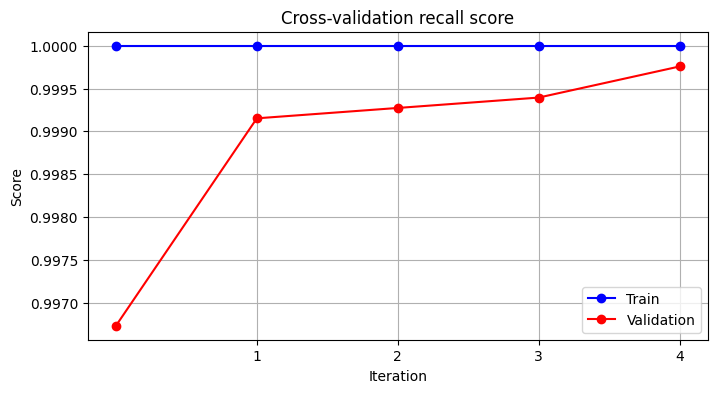

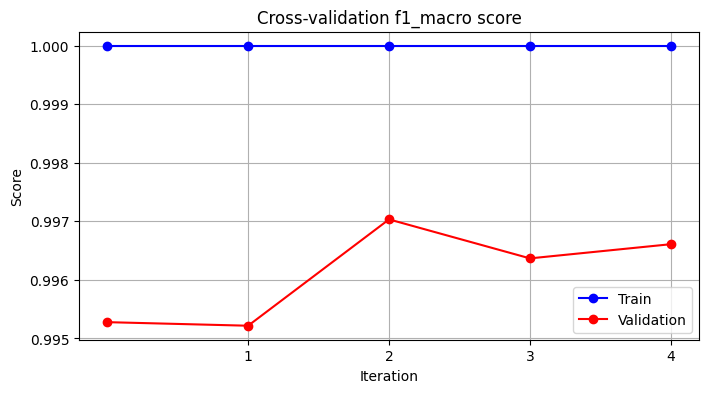

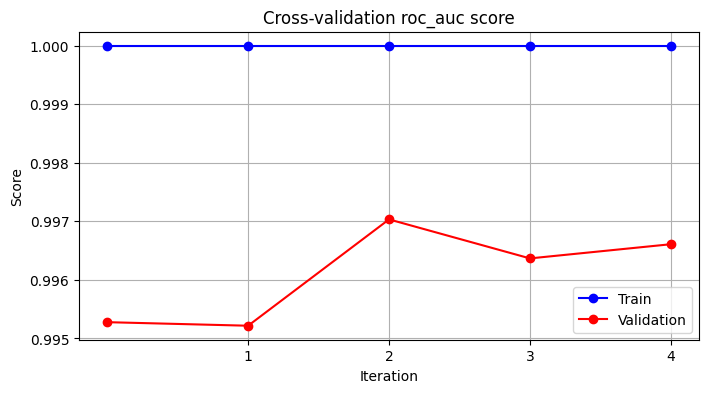

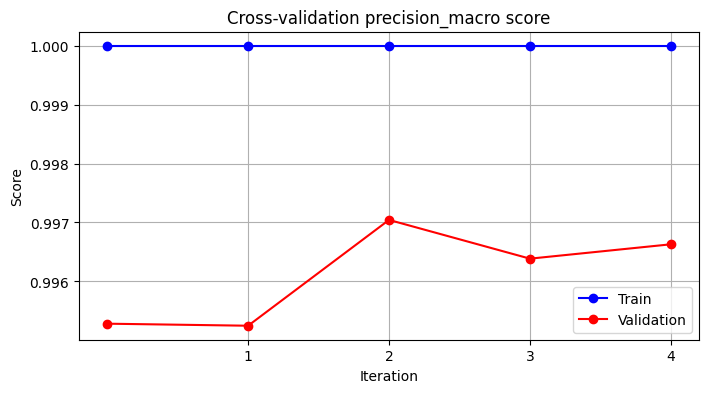

In [238]:
cv_results_ada_rf_clf = cross_validate(estimator=ada_rf_clf,
                                       X=X_train_scaled,
                                       y=y_train_balanced,
                                       scoring=parameters_rf_clf.get('cross_validation')['scores'],
                                       cv=parameters_rf_clf.get('cross_validation')['folders'],
                                       verbose=0,
                                       return_train_score=True,
                                       error_score=np.nan
                                       )

# Calculate cross-validation scores
for score in parameters_rf_clf.get('cross_validation')['scores']:
    cv_train_mean = cv_results_ada_rf_clf[f'train_{score}'].mean().round(4)
    cv_test_mean  = cv_results_ada_rf_clf[f'test_{score}'].mean().round(4)
    plot_cross_validation_score(cv_results_ada_rf_clf, score)
    print(f'>>>>>>>>> CV {score} train mean: {cv_train_mean}')
    print(f'>>>>>>>>> CV {score} test mean:  {cv_test_mean}')

In [239]:
y_pred_ada_rf_clf       = ada_rf_clf.predict(X_val_scaled)
y_pred_proba_ada_rf_clf = ada_rf_clf.predict_proba(X_val_scaled)

Accuracy:        0.99
Precision:       0.71
Recall:          0.78
F1-score:        0.75
Specificity:     0.99
AUC:             0.89

TN:              17608.00
TP:              233.00
FN:              65.00
FP:              94.00

FP rate:         0.53%
FN rate:         21.81%
False clf rate:  0.88%

No defect cost:  940.00
Predictive cost: 5825.00
Corrective cost: 32500.00
Total cost:      39265.00



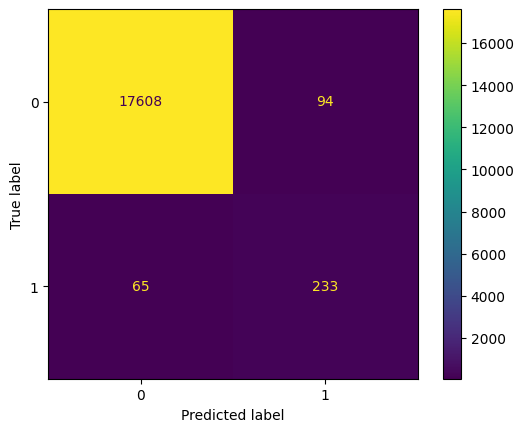

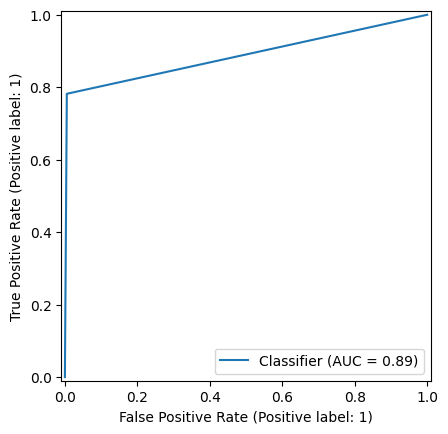

In [240]:
metrics_ada_rf_clf = calculate_metrics_standard_cutoff(y_val, y_pred_ada_rf_clf)

In [241]:
df_pred_proba_ada_rf_clf = pd.DataFrame(y_pred_proba_ada_rf_clf,
                                        columns=['proba_non_event', 'proba_event']
                                       )
df_metrics_ada_rf_clf = calculate_metrics_range_cutoff(df_pred_proba_ada_rf_clf, y_val)
plot_metrics(df_metrics_ada_rf_clf)

### Decision tree

In [243]:
from    sklearn.tree import DecisionTreeClassifier

In [244]:
ada_dt_clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=RANDOM_SEED),
                                random_state=RANDOM_SEED,
                                algorithm='SAMME'
                                )
ada_dt_clf.fit(X_train_scaled, y_train_balanced)

AdaBoostClassifier(algorithm='SAMME', estimator=DecisionTreeClassifier())

#### Cross-validation scores

>>>>>>>>> CV recall train mean: 1.0
>>>>>>>>> CV recall test mean:  0.994
>>>>>>>>> CV f1_macro train mean: 1.0
>>>>>>>>> CV f1_macro test mean:  0.9911
>>>>>>>>> CV roc_auc train mean: 1.0
>>>>>>>>> CV roc_auc test mean:  0.9911
>>>>>>>>> CV precision_macro train mean: 1.0
>>>>>>>>> CV precision_macro test mean:  0.9911


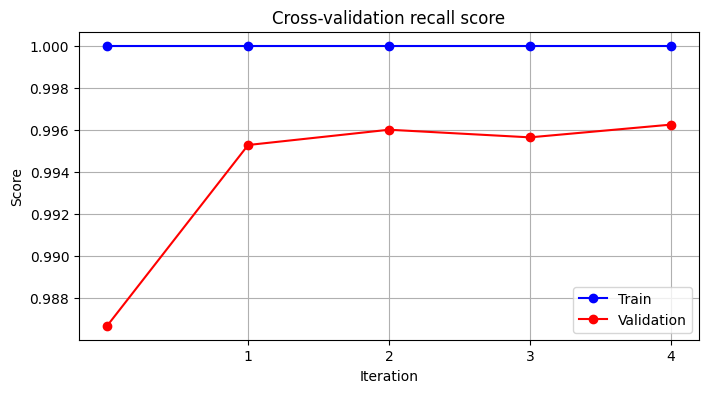

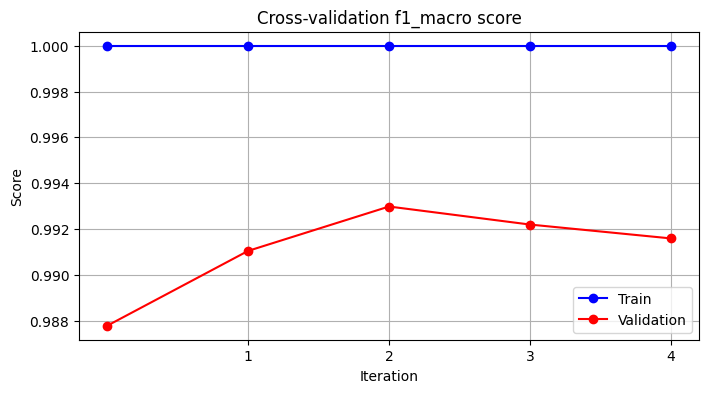

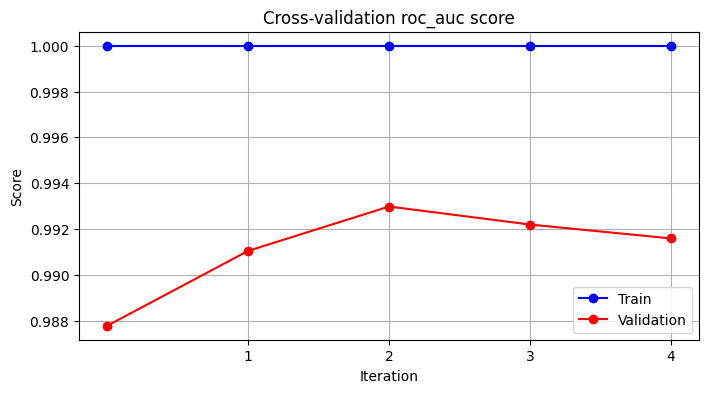

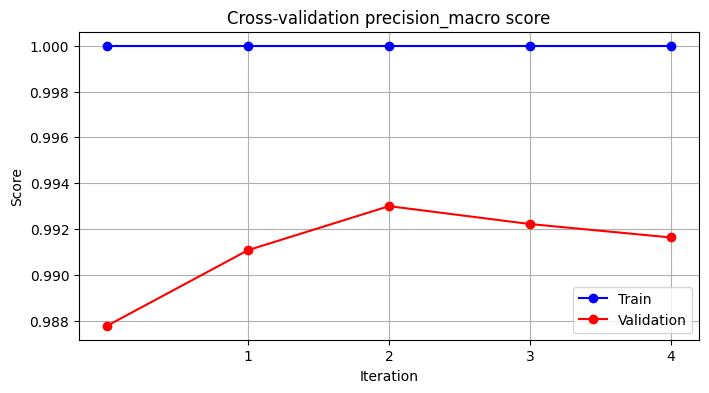

In [245]:
cv_results_ada_dt_clf = cross_validate(estimator=ada_dt_clf,
                                       X=X_train_scaled,
                                       y=y_train_balanced,
                                       scoring=parameters_rf_clf.get('cross_validation')['scores'],
                                       cv=parameters_rf_clf.get('cross_validation')['folders'],
                                       verbose=0,
                                       return_train_score=True,
                                       error_score=np.nan
                                       )

# Calculate cross-validation scores
for score in parameters_rf_clf.get('cross_validation')['scores']:
    cv_train_mean = cv_results_ada_dt_clf[f'train_{score}'].mean().round(4)
    cv_test_mean  = cv_results_ada_dt_clf[f'test_{score}'].mean().round(4)
    plot_cross_validation_score(cv_results_ada_dt_clf, score)
    print(f'>>>>>>>>> CV {score} train mean: {cv_train_mean}')
    print(f'>>>>>>>>> CV {score} test mean:  {cv_test_mean}')

In [246]:
y_pred_ada_dt_clf       = ada_dt_clf.predict(X_val_scaled)
y_pred_proba_ada_dt_clf = ada_dt_clf.predict_proba(X_val_scaled)

Accuracy:        0.99
Precision:       0.55
Recall:          0.67
F1-score:        0.60
Specificity:     0.99
AUC:             0.83

TN:              17538.00
TP:              199.00
FN:              99.00
FP:              164.00

FP rate:         0.93%
FN rate:         33.22%
False clf rate:  1.46%

No defect cost:  1640.00
Predictive cost: 4975.00
Corrective cost: 49500.00
Total cost:      56115.00



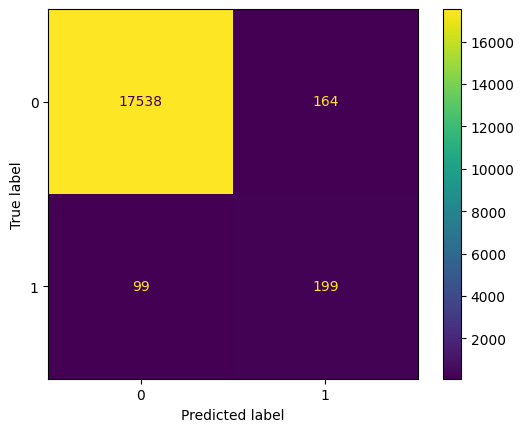

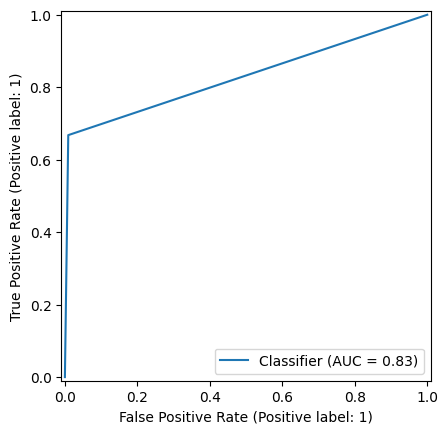

In [247]:
metrics_ada_dt_clf = calculate_metrics_standard_cutoff(y_val, y_pred_ada_dt_clf)

In [248]:
df_pred_proba_ada_dt_clf = pd.DataFrame(y_pred_proba_ada_dt_clf,
                                        columns=['proba_non_event', 'proba_event']
                                        )
df_metrics_ada_dt_clf = calculate_metrics_range_cutoff(df_pred_proba_ada_dt_clf, y_val)
plot_metrics(df_metrics_ada_dt_clf)

# Compare models

## Standard cutoff

In [ ]:
columns = ['accuracy',
           'precision',
           'recall',
           'f1score',
           'auc_value',
           'specificity',
           'tn', 'fp', 'fn', 'tp',
           'false_positive_rate',
           'false_negative_rate',
           'false_classification_rate',
           'no_defect_maintenance_cost',
           'preventive_maintenance_cost',
           'corrective_maintenance_cost',
           'total_maintenance_cost']

df_metrics_standard_cutoff = pd.DataFrame(metrics_rf_clf,
                                          columns=columns
                                         )
df_metrics_standard_cutoff = pd.concat([df_metrics_standard_cutoff,
                                         pd.DataFrame(metrics_rf_clf_tuning, columns=columns)], axis=0)
df_metrics_standard_cutoff = pd.concat([df_metrics_standard_cutoff,
                                         pd.DataFrame(metrics_rf_clf_important_features, columns=columns)], axis=0)
df_metrics_standard_cutoff = pd.concat([df_metrics_standard_cutoff,
                                         pd.DataFrame(metrics_xgb_clf, columns=columns)], axis=0)
df_metrics_standard_cutoff = pd.concat([df_metrics_standard_cutoff,
                                         pd.DataFrame(metrics_xgb_clf_tuning, columns=columns)], axis=0)
df_metrics_standard_cutoff = pd.concat([df_metrics_standard_cutoff,
                                         pd.DataFrame(metrics_xgb_clf_important_features, columns=columns)], axis=0)
df_metrics_standard_cutoff = pd.concat([df_metrics_standard_cutoff,
                                         pd.DataFrame(metrics_mlp_clf, columns=columns)], axis=0)
df_metrics_standard_cutoff = pd.concat([df_metrics_standard_cutoff,
                                         pd.DataFrame(metrics_ada_rf_clf, columns=columns)], axis=0)
df_metrics_standard_cutoff = pd.concat([df_metrics_standard_cutoff,
                                         pd.DataFrame(metrics_ada_dt_clf, columns=columns)], axis=0)
df_metrics_standard_cutoff['model'] = ['rf_clf',
                                       'rf_clf_tuning',
                                       'ada_rf_clf_tuning',
                                       'xgb_clf',
                                       'xgb_clf_tuning',
                                       'xgb_clf_important_features',
                                       'mlp_clf',
                                       'ada_rf_clf',
                                       'ada_dt_clf'
                                       ]
df_metrics_standard_cutoff

,accuracy,precision,recall,f1score,auc_value,specificity,tn,fp,fn,tp,false_positive_rate,false_negative_rate,false_classification_rate,no_defect_maintenance_cost,preventive_maintenance_cost,corrective_maintenance_cost,total_maintenance_cost,model
0,0.991000,0.707317,0.778523,0.741214,0.886550,0.994577,17606,96,66,232,0.542312,22.147651,0.900000,960,5800,33000,39760,rf_clf
0,0.939556,0.210411,0.963087,0.345367,0.951123,0.939159,16625,1077,11,287,6.084058,3.691275,6.044444,10770,7175,5500,23445,rf_clf_tuning
0,0.941111,0.214393,0.959732,0.350490,0.950265,0.940798,16654,1048,12,286,5.920235,4.026846,5.888889,10480,7150,6000,23630,ada_rf_clf_tuning
0,0.992778,0.776316,0.791946,0.784053,0.894052,0.996159,17634,68,62,236,0.384137,20.805369,0.722222,680,5900,31000,37580,xgb_clf
0,0.992778,0.776316,0.791946,0.784053,0.894052,0.996159,17634,68,62,236,0.384137,20.805369,0.722222,680,5900,31000,37580,xgb_clf_tuning
0,0.990278,0.674221,0.798658,0.731183,0.896081,0.993504,17587,115,60,238,0.649644,20.134228,0.972222,1150,5950,30000,37100,xgb_clf_important_features
0,0.990000,0.702055,0.687919,0.694915,0.841502,0.995085,17615,87,93,205,0.491470,31.208054,1.000000,870,5125,46500,52495,mlp_clf
0,0.449000,0.022817,0.771812,0.044325,0.607689,0.443566,7852,9850,68,230,55.643430,22.818792,55.100000,98500,5750,34000,138250,mlp_clf_tuning
0,0.991167,0.712538,0.781879,0.745600,0.888285,0.994690,17608,94,65,233,0.531013,21.812081,0.883333,940,5825,32500,39265,ada_rf_clf
0,0.985389,0.548209,0.667785,0.602118,0.829260,0.990736,17538,164,99,199,0.926449,33.221477,1.461111,1640,4975,49500,56115,ada_dt_clf


In [259]:
lower_total_cost = df_metrics_standard_cutoff['total_maintenance_cost'].min()
select_model = df_metrics_standard_cutoff[df_metrics_standard_cutoff['total_maintenance_cost'] == lower_total_cost]
select_model

,accuracy,precision,recall,f1score,auc_value,specificity,tn,fp,fn,tp,false_positive_rate,false_negative_rate,false_classification_rate,no_defect_maintenance_cost,preventive_maintenance_cost,corrective_maintenance_cost,total_maintenance_cost,model
0,0.939556,0.210411,0.963087,0.345367,0.951123,0.939159,16625,1077,11,287,6.084058,3.691275,6.044444,10770,7175,5500,23445,rf_clf_tuning


In [260]:
for column in df_metrics_standard_cutoff.columns:
    if column != 'model':
        fig = px.bar(df_metrics_standard_cutoff,
                x='model',
                y=column,
                text_auto=True,
                text=column
                )
        fig.update_traces(texttemplate='%{text:.3f}')

        fig.update_layout(height=400,
                        width=800,
                        showlegend=True,
                        margin=dict(l=10, r=10, b=10, t=10),
                        yaxis = dict(title=column.title()),
                        xaxis = dict(title='Model')
                        )
        fig.show()

## Various cutoffs

In [252]:
df_compare_metrics = df_metrics_rf_clf.copy()
df_compare_metrics['model'] = 'rf_clf'

In [ ]:
df_metrics_rf_clf_tuning['model']              = 'rf_clf_tuning'
df_metrics_rf_clf_important_features['model']  = 'rf_clf_important_features'
df_metrics_xgb_clf['model']                    = 'xgb_clf'
df_metrics_xgb_clf_tuning['model']             = 'xgb_clf_tuning'
df_metrics_xgb_clf_important_features['model'] = 'xgb_clf_important_features'
df_metrics_mlp_clf['model']                    = 'mlp_clf'
df_metrics_ada_rf_clf['model']                 = 'ada_rf_clf'
df_metrics_ada_dt_clf['model']                 = 'ada_dt_clf'

df_compare_metrics = pd.concat([df_compare_metrics, df_metrics_rf_clf_tuning], axis=0)
df_compare_metrics = pd.concat([df_compare_metrics, df_metrics_rf_clf_important_features], axis=0)
df_compare_metrics = pd.concat([df_compare_metrics, df_metrics_xgb_clf], axis=0)
df_compare_metrics = pd.concat([df_compare_metrics, df_metrics_xgb_clf_tuning], axis=0)
df_compare_metrics = pd.concat([df_compare_metrics, df_metrics_xgb_clf_important_features], axis=0)
df_compare_metrics = pd.concat([df_compare_metrics, df_metrics_mlp_clf], axis=0)
df_compare_metrics = pd.concat([df_compare_metrics, df_metrics_ada_rf_clf], axis=0)
df_compare_metrics = pd.concat([df_compare_metrics, df_metrics_ada_dt_clf], axis=0)

df_compare_metrics

,cutoff,accuracy,precision,recall,f1score,auc_value,tn,fp,fn,tp,specificity,false_positive_rate,false_negative_rate,false_classification_rate,no_defect_maintenance_cost,preventive_maintenance_cost,corrective_maintenance_cost,total_maintenance_cost,model
0,0.05,0.943056,0.221028,0.966443,0.359775,0.954552,16687,1015,10,288,0.942662,5.733815,3.355705,5.694444,10150,7200,5000,22350,rf_clf
1,0.10,0.962278,0.300105,0.959732,0.457234,0.961026,17035,667,12,286,0.962321,3.767936,4.026846,3.772222,6670,7150,6000,19820,rf_clf
2,0.15,0.971722,0.363519,0.942953,0.524743,0.957580,17210,492,17,281,0.972207,2.779347,5.704698,2.827778,4920,7025,8500,20445,rf_clf
3,0.20,0.977722,0.421613,0.929530,0.580105,0.954032,17322,380,21,277,0.978533,2.146650,7.046980,2.227778,3800,6925,10500,21225,rf_clf
4,0.25,0.982167,0.479789,0.916107,0.629758,0.949693,17406,296,25,273,0.983279,1.672127,8.389262,1.783333,2960,6825,12500,22285,rf_clf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,0.75,0.985389,0.548209,0.667785,0.602118,0.829260,17538,164,99,199,0.990736,0.926449,33.221477,1.461111,1640,4975,49500,56115,ada_dt_clf
15,0.80,0.985389,0.548209,0.667785,0.602118,0.829260,17538,164,99,199,0.990736,0.926449,33.221477,1.461111,1640,4975,49500,56115,ada_dt_clf
16,0.85,0.985389,0.548209,0.667785,0.602118,0.829260,17538,164,99,199,0.990736,0.926449,33.221477,1.461111,1640,4975,49500,56115,ada_dt_clf
17,0.90,0.983444,0.000000,0.000000,0.000000,0.500000,17702,0,298,0,1.000000,0.000000,100.000000,1.655556,0,0,149000,149000,ada_dt_clf


In [254]:
df_compare_metrics.groupby(['cutoff', 'model']).mean()

accuracy  precision    recall   f1score  \
cutoff model                                                                 
0.05   ada_dt_clf                  0.016556   0.016556  1.000000  0.032572   
       ada_rf_clf                  0.016556   0.016556  1.000000  0.032572   
       mlp_clf                     0.985389   0.544304  0.721477  0.620491   
       mlp_clf_tuning              0.449000   0.022817  0.771812  0.044325   
       rf_clf                      0.943056   0.221028  0.966443  0.359775   
...                                     ...        ...       ...       ...   
0.95   rf_clf_important_features   0.979389   0.384127  0.406040  0.394780   
       rf_clf_tuning               0.978556   0.358974  0.375839  0.367213   
       xgb_clf                     0.993000   0.887387  0.661074  0.757692   
       xgb_clf_important_features  0.991833   0.868293  0.597315  0.707753   
       xgb_clf_tuning              0.993000   0.887387  0.661074  0.757692   

                                   auc_value       tn       fp     fn     tp  \
cutoff model                                                                   
0.05   ada_dt_clf                   0.500000      0.0  17702.0    0.0  298.0   
       ada_rf_clf                   0.500000      0.0  17702.0    0.0  298.0   
       mlp_clf                      0.855654  17522.0    180.0   83.0  215.0   
       mlp_clf_tuning               0.607689   7852.0   9850.0   68.0  230.0   
       rf_clf                       0.954552  16687.0   1015.0   10.0  288.0   
...                                      ...      ...      ...    ...    ...   
0.95   rf_clf_important_features    0.697541  17508.0    194.0  177.0  121.0   
       rf_clf_tuning                0.682270  17502.0    200.0  186.0  112.0   
       xgb_clf                      0.829831  17677.0     25.0  101.0  197.0   
       xgb_clf_important_features   0.797895  17675.0     27.0  120.0  178.0   
       xgb_clf_tuning               0.829831  17677.0     25.0  101.0  197.0   

                                   specificity  false_positive_rate  \
cutoff model                                                          
0.05   ada_dt_clf                     0.000000           100.000000   
       ada_rf_clf                     0.000000           100.000000   
       mlp_clf                        0.989832             1.016834   
       mlp_clf_tuning                 0.443566            55.643430   
       rf_clf                         0.942662             5.733815   
...                                        ...                  ...   
0.95   rf_clf_important_features      0.989041             1.095921   
       rf_clf_tuning                  0.988702             1.129816   
       xgb_clf                        0.998588             0.141227   
       xgb_clf_important_features     0.998475             0.152525   
       xgb_clf_tuning                 0.998588             0.141227   

                                   false_negative_rate  \
cutoff model                                             
0.05   ada_dt_clf                             0.000000   
       ada_rf_clf                             0.000000   
       mlp_clf                               27.852349   
       mlp_clf_tuning                        22.818792   
       rf_clf                                 3.355705   
...                                                ...   
0.95   rf_clf_important_features             59.395973   
       rf_clf_tuning                         62.416107   
       xgb_clf                               33.892617   
       xgb_clf_important_features            40.268456   
       xgb_clf_tuning                        33.892617   

                                   false_classification_rate  \
cutoff model                                                   
0.05   ada_dt_clf                                  98.344444   
       ada_rf_clf                                  98.344444   
       mlp_clf                              

In [261]:
min_total_cost = df_compare_metrics['total_maintenance_cost'].min()
df_compare_metrics[df_compare_metrics['total_maintenance_cost'] == min_total_cost]

,cutoff,accuracy,precision,recall,f1score,auc_value,tn,fp,fn,tp,specificity,false_positive_rate,false_negative_rate,false_classification_rate,no_defect_maintenance_cost,preventive_maintenance_cost,corrective_maintenance_cost,total_maintenance_cost,model
1,0.1,0.962278,0.300105,0.959732,0.457234,0.961026,17035,667,12,286,0.962321,3.767936,4.026846,3.772222,6670,7150,6000,19820,rf_clf


In [257]:
df_compare_metrics[df_compare_metrics['cutoff'] == 0.5]

,cutoff,accuracy,precision,recall,f1score,auc_value,tn,fp,fn,tp,specificity,false_positive_rate,false_negative_rate,false_classification_rate,no_defect_maintenance_cost,preventive_maintenance_cost,corrective_maintenance_cost,total_maintenance_cost,model
9,0.5,0.991000,0.707317,0.778523,0.741214,0.886550,17606,96,66,232,0.994577,0.542312,22.147651,0.900000,960,5800,33000,39760,rf_clf
9,0.5,0.939556,0.210411,0.963087,0.345367,0.951123,16625,1077,11,287,0.939159,6.084058,3.691275,6.044444,10770,7175,5500,23445,rf_clf_tuning
9,0.5,0.941111,0.214393,0.959732,0.350490,0.950265,16654,1048,12,286,0.940798,5.920235,4.026846,5.888889,10480,7150,6000,23630,rf_clf_important_features
9,0.5,0.992778,0.776316,0.791946,0.784053,0.894052,17634,68,62,236,0.996159,0.384137,20.805369,0.722222,680,5900,31000,37580,xgb_clf
9,0.5,0.992778,0.776316,0.791946,0.784053,0.894052,17634,68,62,236,0.996159,0.384137,20.805369,0.722222,680,5900,31000,37580,xgb_clf_tuning
9,0.5,0.990278,0.674221,0.798658,0.731183,0.896081,17587,115,60,238,0.993504,0.649644,20.134228,0.972222,1150,5950,30000,37100,xgb_clf_important_features
9,0.5,0.990000,0.702055,0.687919,0.694915,0.841502,17615,87,93,205,0.995085,0.491470,31.208054,1.000000,870,5125,46500,52495,mlp_clf
9,0.5,0.449000,0.022817,0.771812,0.044325,0.607689,7852,9850,68,230,0.443566,55.643430,22.818792,55.100000,98500,5750,34000,138250,mlp_clf_tuning
9,0.5,0.991167,0.712538,0.781879,0.745600,0.888285,17608,94,65,233,0.994690,0.531013,21.812081,0.883333,940,5825,32500,39265,ada_rf_clf
9,0.5,0.985389,0.548209,0.667785,0.602118,0.829260,17538,164,99,199,0.990736,0.926449,33.221477,1.461111,1640,4975,49500,56115,ada_dt_clf


# Test

In [ ]:
df_test = pd.read_csv('data\\original\\air_system_present_year.csv',
                      encoding='utf-8',
                      na_values=['na']
                      )

In [ ]:
df_test_target = df_test[['class']]
# Change class to int dummies
map_class = {'neg': 0, 'pos': 1}
df_test_target.loc[:, 'class'] = df_test_target['class'].map(map_class)
y_test = df_test_target['class'].astype(int)
y_test

In [ ]:
# Calculate events proportion
total_test     = df_test_target.shape[0]
non_event_test = df_test_target[df_test_target['class'] == 0].shape[0]
event_test     = df_test_target[df_test_target['class'] == 1].shape[0]

non_event_test_percent = round(non_event_test / total_test * 100, 2)
event_test_percent     = round(event_test / total_test * 100, 2)

non_event_test_percent, event_test_percent

In [ ]:
df_test_features = df_test[X_train_balanced.columns]
df_test_features = df_test_features.astype(float)
df_test_features

In [ ]:
df_test_features.isna().sum().sort_values(ascending=False)

## Input data on NaN

In [ ]:
X_test_filled_nan = imputer.transform(df_test_features)
X_test_filled_nan = pd.DataFrame(X_test_filled_nan, columns=df_test_features.columns)
X_test_filled_nan.isna().sum().sum()

In [ ]:
X_test_filled_nan.head()

# Predict